In [1]:
%load_ext autoreload
%autoreload 2
!conda install -c conda-forge -y pint-xarray
import os
import warnings

warnings.filterwarnings('ignore')

if os.path.isdir('/share/share/ESCI345'):
    os.environ["ARTS_DATA_PATH"] = "/share/share/ESCI345/"
    os.environ["ARTS_XML_ATMO"] = "/share/share/ESCI345/atmospheres/"
else:
    os.environ["ARTS_DATA_PATH"] = "/Users/wgblumbe/Code/rttools/arts_catalogs/arts-cat-data-snapshot-arts-2.5.8/"
    os.environ["ARTS_XML_ATMO"] = "/Users/wgblumbe/Code/rttools/ESCI345/atmospheres/"

import proplot as pplt
import matplotlib.pyplot as plt
import numpy as np
import pint
import re
import optical_depth
import rtcalc_module

pplt.use_style("seaborn-talk")
pplt.rc["legend.facecolor"] = "white"

ureg = pint.UnitRegistry()

def tag2tex(tag):
    """Replace all numbers in a species tag with LaTeX subscripts."""
    return re.sub("([a-zA-Z]+)([0-9]+)", r"\1$_{\2}$", tag)

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/wgblumbe/miniconda3/envs/Spring24

  added / updated specs:
    - pint-xarray


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.2.1              |       h0d3ecfb_1         2.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.7 MB

The following packages will be UPDATED:

  openssl                                  3.2.1-h0d3ecfb_0 --> 3.2.1-h0d3ecfb_1



openssl-3.2.1        | 2.7 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
freq_bounds = (20 * pint.Unit("micrometers"), 6 * pint.Unit("micrometers"))
freq_bounds = (10 * pint.Unit("GHz"), 200 * pint.Unit("GHz"))

atmosphere = 'midlatitude-winter' #midlatitude-summer, midlatitude-winter, subarctic-summer, subarctic-winter
profiles, optical_depths, freq = optical_depth.atmo_optical_depth(fbounds=freq_bounds, 
                                                                  atmosphere=atmosphere, 
                                                                  abs_species=optical_depth.getInfraredAbsorbers(),
                                                                  fnum=1_000)

In [4]:
#print(profiles)
temp_pert_profiles = profiles.rename({'Temperature':'t', "Pressure":'p', "Height":'z'}, axis=1)
#print(temp_pert_profiles)
temp_pert_profiles['t'] += 0.01
#temp_pert_profiles

profiles_tpert, pert_t_od, freq = optical_depth.atmo_optical_depth(fbounds=freq_bounds, 
                                                                  atmosphere=temp_pert_profiles, 
                                                                  abs_species=optical_depth.getInfraredAbsorbers(),
                                                                  fnum=1_000)


In [5]:
#print(profiles)
q_pert_profiles = profiles.rename({'Temperature':'t', "Pressure":'p', "Height":'z'}, axis=1)
#print(q_pert_profiles['H2O'])
q_pert_profiles['H2O'] =  0.000001 + q_pert_profiles['H2O']
#print(q_pert_profiles['H2O'])
#stop
profiles_qpert, pert_q_od, freq = optical_depth.atmo_optical_depth(fbounds=freq_bounds, 
                                                                  atmosphere=q_pert_profiles, 
                                                                  abs_species=optical_depth.getInfraredAbsorbers(),
                                                                  fnum=1_000)


In [6]:
zenith = 0
surface_temperature = 310 # K
surface_emissivity = 1

wnum = freq.to("1/centimeter", "spectroscopy")
gas_opd = optical_depths.sum(axis=0).T
gas_tpert_opd = optical_depths.sum(axis=0).T
gas_qpert_opd = pert_q_od.sum(axis=0).T


temp_profile = profiles['Temperature'].to_numpy()
ptemp_profile = profiles_tpert['Temperature'].to_numpy()
rad_dn = rtcalc_module.rt(opd = gas_opd, wnum = wnum, temp = temp_profile, zenith_angle=zenith, upwelling=False,
                          sfc_t=310, sfc_e=1)

jacobian_dn_t = []
for i in range(len(profiles['Temperature'].to_numpy())):
    pert_temp_profile = temp_profile.copy()
    pert_temp_profile[i] = ptemp_profile[i]
    rad_dn_t = rtcalc_module.rt(opd = gas_opd, wnum = wnum, temp = pert_temp_profile, zenith_angle=zenith, upwelling=False,
                          sfc_t=310, sfc_e=1)
    jacobian_dn_t.append((rad_dn_t - rad_dn)/0.01)

jacobian_dn_q = []
for i in range(len(profiles['Temperature'].to_numpy())-1):
    pert_q_ods = gas_opd.copy()
    pert_q_ods[i] = gas_qpert_opd[i]
    rad_dn_q = rtcalc_module.rt(opd = pert_q_ods, wnum = wnum, temp = temp_profile, zenith_angle=zenith, upwelling=False,
                          sfc_t=310, sfc_e=1)
    jacobian_dn_q.append((rad_dn_q - rad_dn)/0.000001)


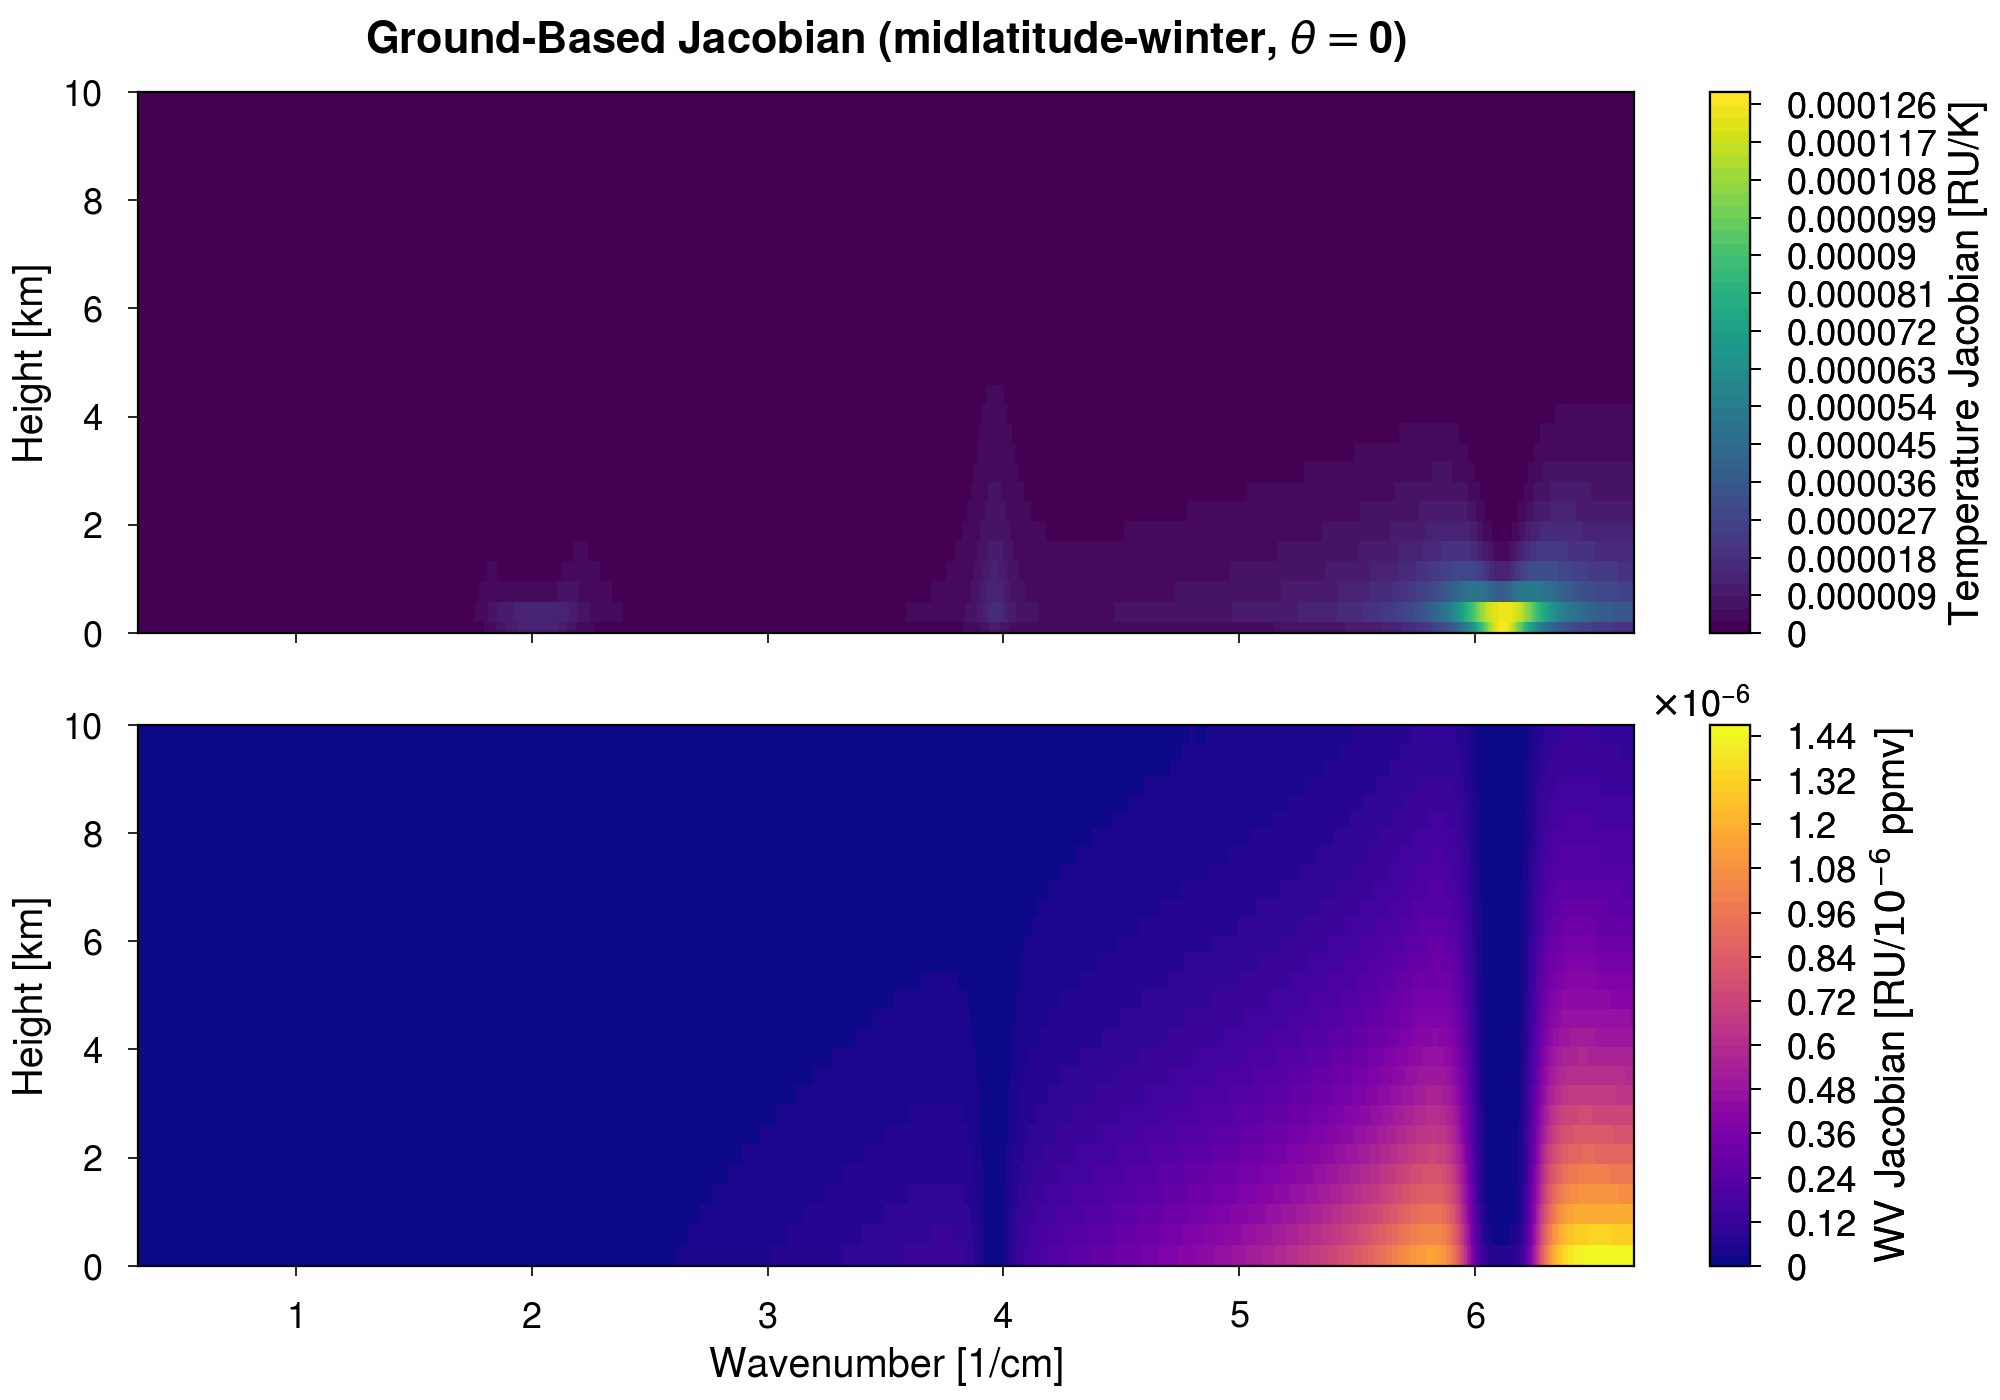

In [7]:
jacobian_dn_t = np.asarray(jacobian_dn_t)
fig, ax = pplt.subplots(nrows=2, ncols=1, figsize=(10,7), sharex=True, sharey=False)
fig.format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Height [km]", grid=True,
          suptitle=rf"Ground-Based Jacobian ({atmosphere}, $\theta=${zenith})",
          ylim=(0,10))
#c = ax[0].pcolormesh(wnum, profiles['Height'].to_numpy()/1000., jacobian_dn_t, levels=50, vmin=0, vmax=.5)
c = ax[0].pcolormesh(wnum, profiles['Height'].to_numpy()/1000., jacobian_dn_t, levels=50)

ax[0].colorbar(c, label="Temperature Jacobian [RU/K]")

jacobian_dn_q = np.asarray(jacobian_dn_q)

#c = ax[1].pcolormesh(wnum, optical_depths.layer_center/1000., jacobian_dn_q*1e-6 , levels=50, vmin=0, vmax=0.001, cmap='plasma')
c = ax[1].pcolormesh(wnum, optical_depths.layer_center/1000., jacobian_dn_q*1e-6 , levels=50, cmap='plasma')

ax[1].colorbar(c, label="WV Jacobian [RU/$10^{-6}$ ppmv]")
fig.save("plots/ground_jacobian.pdf")
plt.show()

In [8]:
zenith = 0
surface_temperature = 310 # K
surface_emissivity = 1

wnum = freq.to("1/centimeter", "spectroscopy")
gas_opd = optical_depths.sum(axis=0).T
gas_tpert_opd = optical_depths.sum(axis=0).T
gas_qpert_opd = pert_q_od.sum(axis=0).T


temp_profile = profiles['Temperature'].to_numpy()
ptemp_profile = profiles_tpert['Temperature'].to_numpy()
rad_dn = rtcalc_module.rt(opd = gas_opd, wnum = wnum, temp = temp_profile, zenith_angle=zenith, upwelling=True,
                          sfc_t=temp_profile[0], sfc_e=1)

jacobian_dn_t = []
for i in range(len(profiles['Temperature'].to_numpy())):
    pert_temp_profile = temp_profile.copy()
    pert_temp_profile[i] = ptemp_profile[i]
    rad_dn_t = rtcalc_module.rt(opd = gas_opd, wnum = wnum, temp = pert_temp_profile, zenith_angle=zenith, upwelling=True,
                          sfc_t=temp_profile[0], sfc_e=1)
    jacobian_dn_t.append((rad_dn_t - rad_dn)/0.01)

jacobian_dn_q = []
for i in range(len(profiles['Temperature'].to_numpy())-1):
    pert_q_ods = gas_opd.copy()
    #print(gas_qpert_opd.shape, pert_q_ods.shape)
    pert_q_ods[i] = gas_qpert_opd[i]
    rad_dn_q = rtcalc_module.rt(opd = pert_q_ods, wnum = wnum, temp = temp_profile, zenith_angle=zenith, upwelling=True,
                          sfc_t=temp_profile[0], sfc_e=1)
    jacobian_dn_q.append((rad_dn_q - rad_dn)/0.000001)

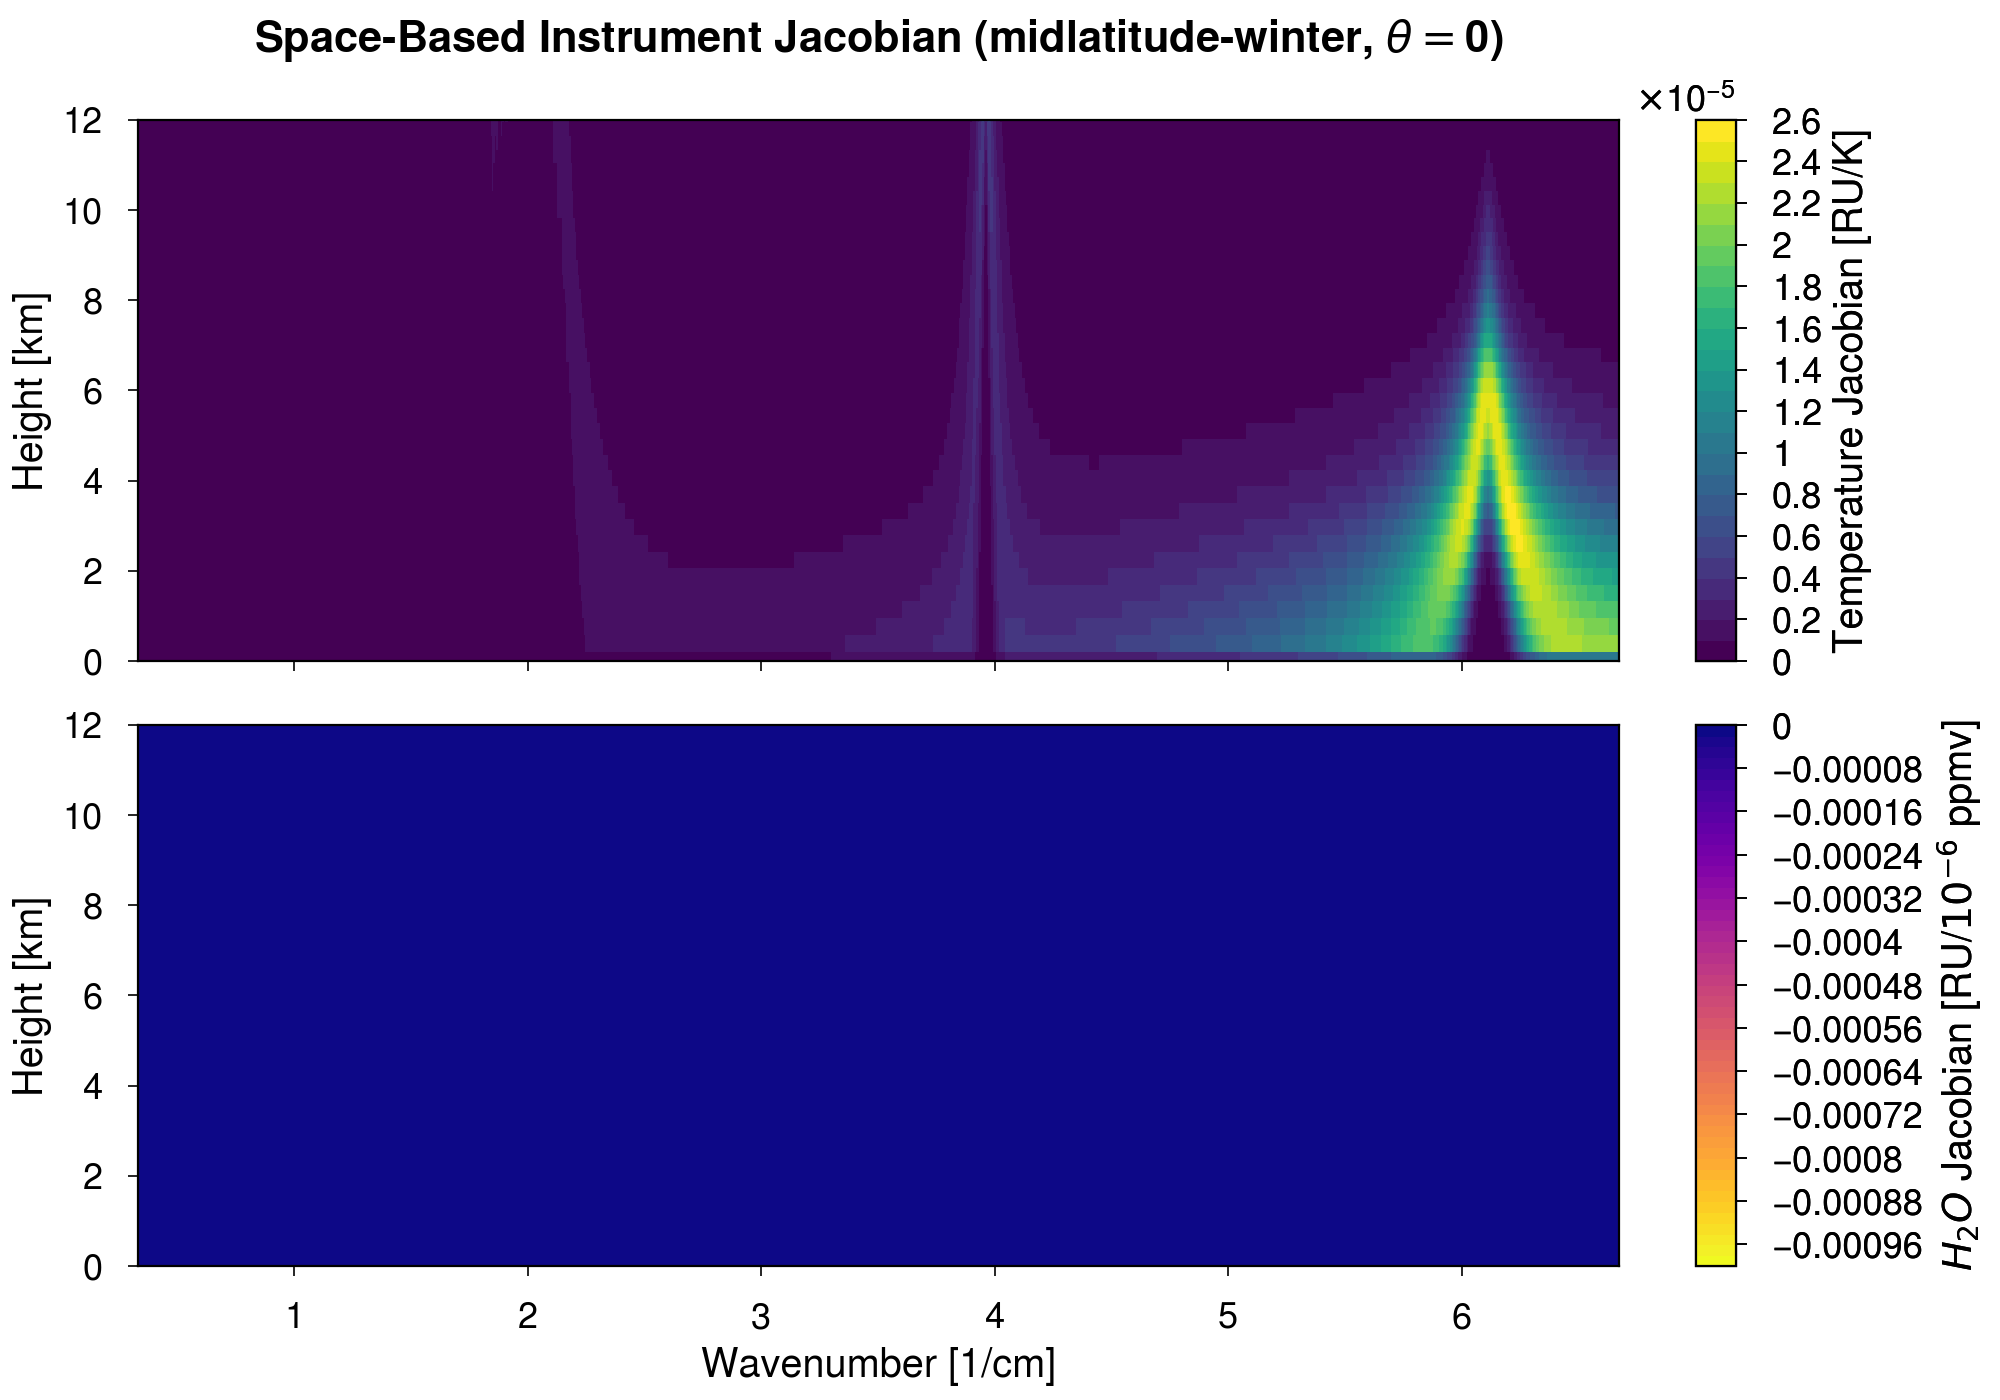

In [9]:
jacobian_dn_t = np.asarray(jacobian_dn_t)
fig, ax = pplt.subplots(nrows=2, ncols=1, figsize=(10,7), sharex=True, sharey=False)
fig.format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Height [km]", grid=True,
          suptitle=rf"Space-Based Instrument Jacobian ({atmosphere}, $\theta=${zenith})",
          ylim=(0,12))
c = ax[0].pcolormesh(wnum, profiles['Height'].to_numpy()/1000., jacobian_dn_t, levels=30)

ax[0].colorbar(c, label="Temperature Jacobian [RU/K]")

jacobian_dn_q = np.asarray(jacobian_dn_q)
ax[1].format(xlabel=f"Wavenumber [{wnum.units:P~}]", ylabel="Height [km]", grid=True,
          ylim=(0,12))
c = ax[1].pcolormesh(wnum, optical_depths.layer_center/1000., jacobian_dn_q*1e-6 , levels=50, vmin=-0.001, vmax=0, cmap='plasma_r')
#c = ax[1].pcolormesh(wnum, optical_depths.layer_center/1000., jacobian_dn_q*1e-6 , levels=50, cmap='plasma_r')

ax[1].colorbar(c, label="$H_2 O$ Jacobian [RU/$10^{-6}$ ppmv]")
fig.save("plots/space_jacobian.pdf")
plt.show()